In [123]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [95]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chronic Kidney Disease Detection/kidney_disease.csv')
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [97]:
# convert the target attribute to four categorical sections:
'''
0 (Healthy)	No CKD	sc < 1.2 (normal serum creatinine) & bu < 20
1 (Early CKD)	Mild	1.2 ≤ sc < 2.0 OR 20 ≤ bu < 40
2 (Moderate CKD)	Moderate	2.0 ≤ sc < 4.5 OR 40 ≤ bu < 70
3 (Severe CKD)	Severe	sc ≥ 4.5 OR bu ≥ 70
'''
def classifyTargetAttribute(sc, bu):
    if (sc < 1.2 and bu < 20):
        return 0
    elif (sc >= 1.2 and sc < 2.0) or (bu >= 20 and bu < 40):
        return 1
    elif (sc >= 2.0 and sc < 4.5) or (bu >= 40 and bu < 70):
        return 2
    else:
        return 3


data["classification"] = data.apply(lambda row: classifyTargetAttribute(row['sc'], row['bu']), axis=1)


In [98]:
# finding null values the dataframe
null_values = data.isnull().sum()
print(null_values)

print("Data types:")
print(data.dtypes)

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64
Data types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo         

In [99]:
# From our findings round 38 percent of Red Blood Cell count (RBC) is missing, and 17 percent of Pus Cells (PC) is missing. Due to its large
# abundance of missing values, and its categorical nature which prevents us from replacing the missing values with a median, we're going to be
# removing features from our dataset

data = data.drop('rbc', axis=1)
data = data.drop('pc', axis=1)

In [100]:
data.columns = data.columns.str.strip()
# Now for the rest of the missing numerical values, we're going to be replacing it with the median, which is median imputation, for each category
# so it wouldn't be biased towards certain ends of the scale of the independent variable
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns[:-1]
data[numerical_columns] = data[numerical_columns].apply(lambda x: x.fillna(x.median()))

# replaced missing categorical data with mode imputation for the rest of the columns who's values aren't missing significantly
# This allows us to have the complete number of observations
categorical_columns = data.select_dtypes(include = ['object']).columns
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.fillna(x.mode()))

In [101]:
print(data.shape[0])

400


In [102]:

Y = data['classification']
X = data.drop('classification', axis=1)



In [103]:
# Normalize the features of the data

# Create a pipeline
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# This standardizes the numerical_columns
numerical_pipeline = Pipeline([
    ('standardize', StandardScaler())
])

# This does One-Hot Encoding of each categorical column
categorical_pipeline = Pipeline([
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', LogisticRegression(penalty='l2',  solver='lbfgs', C=0.1, max_iter=1000))
])



In [104]:
numerical_columns[:-1]

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot'], dtype='object')

In [105]:
X_train

,id,age,bp,sg,al,su,pcc,ba,bgr,bu,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
124,124,65.0,100.0,1.015,0.0,0.0,notpresent,notpresent,90.0,98.0,...,9.1,28,5500,3.6,yes,no,no,good,no,no
294,294,75.0,60.0,1.020,0.0,0.0,notpresent,notpresent,110.0,50.0,...,14.3,40,8300,5.8,no,no,no,NaN,NaN,NaN
255,255,34.0,80.0,1.025,0.0,0.0,notpresent,notpresent,121.0,27.0,...,13.6,52,9200,6.3,no,no,no,good,no,no
78,78,70.0,80.0,1.020,0.0,0.0,notpresent,notpresent,158.0,85.0,...,10.1,30,NaN,NaN,yes,no,no,good,yes,no
101,101,71.0,90.0,1.015,2.0,0.0,present,present,88.0,80.0,...,11.3,33,10700,3.9,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,71,46.0,60.0,1.010,1.0,0.0,notpresent,notpresent,163.0,92.0,...,9.8,28,14600,3.2,yes,yes,no,good,no,no
106,106,50.0,90.0,1.020,0.0,0.0,notpresent,notpresent,89.0,118.0,...,6.0,17,6500,NaN,yes,yes,no,good,yes,yes
270,270,23.0,80.0,1.025,0.0,0.0,notpresent,notpresent,111.0,34.0,...,14.3,41,7200,5.0,no,no,no,good,no,no
348,348,38.0,80.0,1.020,0.0,0.0,notpresent,notpresent,99.0,19.0,...,13.6,44,7300,6.4,no,no,no,good,no,no


In [106]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
       'hemo'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe',
       'ane'],
      dtype='object'))])),
                ('model', LogisticRegression(C=0.1, max_iter=1000))])

In [107]:
pipeline.fit(X_train, y_train)

pipeline.predict(X_test)

'''
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'The best hyperparameters: {grid_search.best_params_}')
print(f"Best Accuracy: {grid_search.best_score_}")
'''

'\ngrid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\nprint(f\'The best hyperparameters: {grid_search.best_params_}\')\nprint(f"Best Accuracy: {grid_search.best_score_}")\n'

In [108]:
pipeline.predict_proba(X_test)


array([[2.17215565e-01, 4.35562635e-01, 2.04410364e-01, 1.42811436e-01],
       [8.40745843e-02, 7.06487687e-01, 1.73105903e-01, 3.63318252e-02],
       [5.30391229e-02, 3.79563079e-01, 3.72494634e-01, 1.94903164e-01],
       [5.70828449e-04, 5.21822020e-03, 2.52647549e-01, 7.41563402e-01],
       [3.25324354e-03, 1.14202646e-01, 7.31480803e-01, 1.51063307e-01],
       [6.90531660e-05, 3.27132251e-04, 9.48667098e-02, 9.04737105e-01],
       [2.06403501e-01, 5.72140887e-01, 1.80048804e-01, 4.14068079e-02],
       [3.59158767e-02, 5.39233584e-01, 3.16239942e-01, 1.08610598e-01],
       [1.28130575e-01, 6.64795276e-01, 1.71786337e-01, 3.52878124e-02],
       [4.54595231e-03, 7.32856244e-02, 4.91631005e-01, 4.30537418e-01],
       [3.59571273e-03, 3.40948035e-02, 4.97607318e-01, 4.64702165e-01],
       [1.89324434e-01, 5.53704233e-01, 2.16368788e-01, 4.06025452e-02],
       [1.36135286e-04, 8.88743832e-03, 6.18229492e-01, 3.72746934e-01],
       [1.78281751e-02, 6.99187076e-01, 2.24898090e

In [109]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f'The best hyperparameters: {grid_search.best_params_}')
print(f"Best Accuracy (CV): {grid_search.best_score_}")

# Evaluate on test set using best model
test_score = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_score}")

print(f"From our findings, the training accuracy is 0.62 while the test accuracy is 0.61. Since the difference between the training and the test accuracy is")
print(f"marginal, it ensures that the model is not overfitting, and the futher regularization isn't needed. But due to the high training error, ")
print(f"it can be due the model underfitting the training data. Therefore, a more sophiticated model is ideal. ")

The best hyperparameters: {'model__C': 0.1}
Best Accuracy (CV): 0.6294117647058823
Test Accuracy: 0.6166666666666667
From our findings, the training accuracy is 0.62 while the test accuracy is 0.61. Since the difference between the training and the test accuracy is
marginal, it ensures that the model is not overfitting, and the futher regularization isn't needed. But due to the high training error, 
it can be due the model underfitting the training data. Therefore, a more sophiticated model is ideal. 


Error Analysis


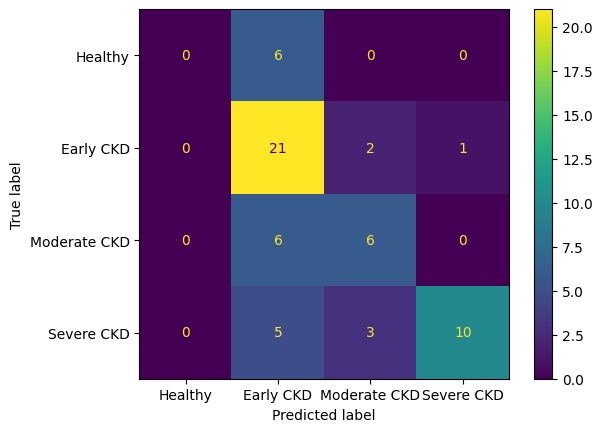

In [110]:
print("Error Analysis")
labels = ["Healthy", "Early CKD", "Moderate CKD", "Severe CKD"]
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [111]:
print("Now, I'm going to be going a seperate approach. Since it was evident that our model was severely underfitting the data, and that a ")
print("more powerful model is necessary, we're going to be implementing random forest approach to evaluate our data.")

rand_forest = RandomForestClassifier(n_estimators=30)
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)
rand_forest.fit(X_train, y_train)
rand_forest.predict(X_test)

param_grid_trees = {
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_trees = GridSearchCV(rand_forest, param_grid_trees, cv=4, scoring='accuracy')
grid_search_trees.fit(X_train, y_train)
grid_search_trees.predict(X_test)
grid_search_trees.predict_proba(X_test)

# Best hyperparameters
print(f'The best hyperparameters: {grid_search_trees.best_params_}')
print(f"Best Accuracy (CV): {grid_search_trees.best_score_}")
test_score1 = grid_search_trees.score(X_test, y_test)
print(f"Test Accuracy: {test_score1}")

Now, I'm going to be going a seperate approach. Since it was evident that our model was severely underfitting the data, and that a 
more powerful model is necessary, we're going to be implementing random forest approach to evaluate our data.
The best hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy (CV): 0.7941176470588235
Test Accuracy: 0.75


In [112]:
print("When training with a random forest classifier, and running a grid search to find the best hyperparameters that maximizes the performance")
print("metric of accuracy, we've found that the max_depth of 20, min_samples_split: 2, and n_estimators of 40 seems to the optimal values. With a")
print("new accuracy of around 0.78, it significantly improved our model by around 0.15 when compared to the softmax regression model that was")
print("used previously. We'll try to further this improvement of accuracy via Extreme Gradient Boosting approach which sequencially trains models")
print("in which the model will learn from the mistakes of its precessors")

When training with a random forest classifier, and running a grid search to find the best hyperparameters that maximizes the performance
metric of accuracy, we've found that the max_depth of 20, min_samples_split: 2, and n_estimators of 40 seems to the optimal values. With a
new accuracy of around 0.78, it significantly improved our model by around 0.15 when compared to the softmax regression model that was
used previously. We'll try to further this improvement of accuracy via Extreme Gradient Boosting approach which sequencially trains models
in which the model will learn from the mistakes of its precessors


Text(0.5, 0, 'Training examples')

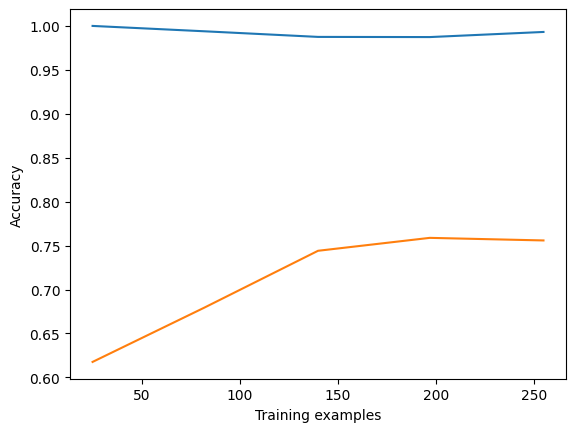

In [113]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search_trees.best_estimator_, X_train, y_train, cv=4, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training examples')

In [114]:
print("As you can see, the model is highly overfitting the data. More regularization is required.")

As you can see, the model is highly overfitting the data. More regularization is required.


In [115]:
param_grid_trees_2 = {
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features' : ["log2", 3, 4, 5]
}
print("We're going to run a randomSearch because it's better than GridSearch in finding hyperparameters that won't overfit the data.")
rand_search_trees = RandomizedSearchCV(rand_forest, param_grid_trees_2, scoring='accuracy', n_iter = 10, refit=True, cv=4)
rand_search_trees.fit(X_train, y_train)
rand_search_trees.predict(X_test)
print(rand_search_trees.get_params(deep=True))
test_score2 = rand_search_trees.score(X_test, y_test)
print(f"Test Accuracy: {test_score2}")
# rand_search_trees.predict_proba(X_train)

We're going to run a randomSearch because it's better than GridSearch in finding hyperparameters that won't overfit the data.
{'cv': 4, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 30, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(n_estimators=30), 'n_iter': 10, 'n_jobs': None, 'param_distributions': {'n_estimators': [10, 20, 30, 40, 50, 60], 'max_depth': [None, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10], 'm

Text(0.5, 0, 'Training examples')

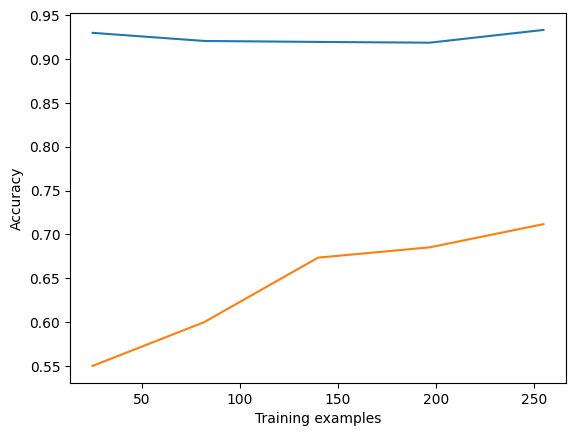

In [116]:
train_sizes1, train_scores1, test_scores1 = learning_curve(
    rand_search_trees.best_estimator_, X_train, y_train, cv=4, scoring='accuracy', n_jobs=-1)

train_scores_mean1 = np.mean(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)

plt.plot(train_sizes1, train_scores_mean1, label='Training score')
plt.plot(train_sizes1, test_scores_mean1, label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training examples')

In [117]:
print("It looks like the model isn't overfitting the data as much as it did before through GridSearch. But it seems to have generalized worse with random search since the test accuracy was lower by 0.06.")
print("We'll proceed with a more random model that'll further generalize better by reducing variance, with a potential tradeoff of bias.")

It looks like the model isn't overfitting the data as much as it did before through GridSearch. But it seems to have generalized worse with random search since the test accuracy was lower by 0.06.
We'll proceed with a more random model that'll further generalize better by reducing variance, with a potential tradeoff of bias.


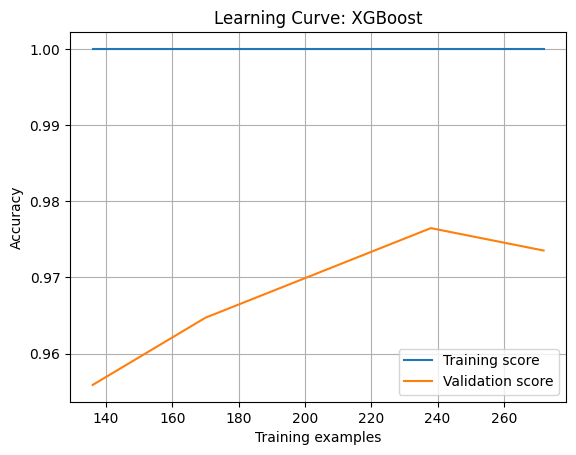

In [126]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='mlogloss',
    use_label_encoder=False
)

cv_strategy = StratifiedKFold(n_splits=5)

train_sizes2, train_scores2, test_scores2 = learning_curve(xgb_model,X_train,y_train_encoded,train_sizes=np.linspace(0.5, 1.0, 5),   scoring='accuracy',n_jobs=-1,cv=cv_strategy,error_score='raise'
)

train_scores_mean2 = np.mean(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)

plt.plot(train_sizes2, train_scores_mean2, label='Training score')
plt.plot(train_sizes2, test_scores_mean2, label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training examples')
plt.legend()
plt.title('Learning Curve: XGBoost')
plt.grid()
plt.show()


In [127]:

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9833
